# Exploring Mental Health Data
Source: https://www.kaggle.com/competitions/playground-series-s4e11

Followed this set-up a bit. I like the flow: https://www.kaggle.com/code/oscarm524/ps-s4-ep11-eda-modeling-submission

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import flax.linen as nn
from flax.training.train_state import TrainState
import optax

In [ ]:
#TODO: add the jax PU selection
#TODO: look how to improve the model
#TODO: look at predictions

In [283]:
# get data
data_path = Path("~/Data/mental_health/")
train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)
test = pd.read_csv(data_path/ "test.csv", header = 0, index_col = 0)
submission = pd.read_csv(data_path/ "sample_submission.csv")


train.shape, test.shape, submission.shape

((140700, 19), (93800, 18), (93800, 2))

In [284]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [285]:
# Check for missing values
print('--- Percentage of Missing Values in Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Percentage of Missing Values in Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Percentage of Missing Values in Train ---

Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                         

In [286]:
# Check for duplicated rows
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the Depression column, there are {sum(train.drop(columns=['Depression'], axis=1).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the Depression column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


### Data Exploration ###

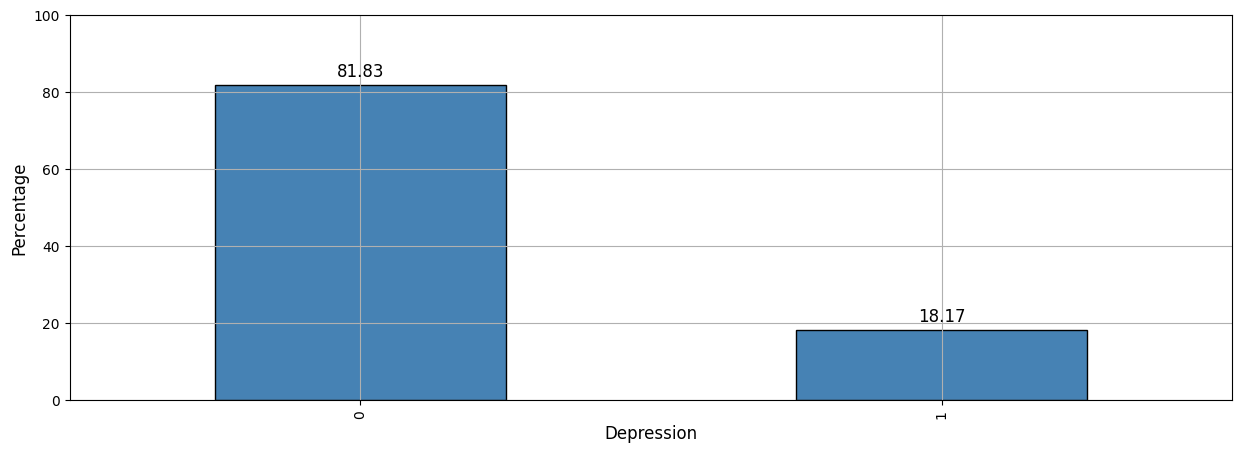

In [287]:
# Plot the distribution of Depression
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = round(train['Depression'].value_counts(normalize=True) * 100, 2).plot(kind='bar', color='steelblue', edgecolor='black')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=12, padding=3)
ax.set_ylabel("Percentage", fontsize=12)
ax.set_xlabel("Depression", fontsize=12)
ax.set_ylim(0, 100)
ax.grid(True)
plt.show()

# We see that we have an imbalanced dataset. We will need to address this later on.

In [288]:
train.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [289]:
# For the categorical variables, count the number of unique values
for col in train.columns:
    if train[col].dtype == 'object':
        print(f"{col}: {train[col].nunique()} unique values")

Name: 422 unique values
Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


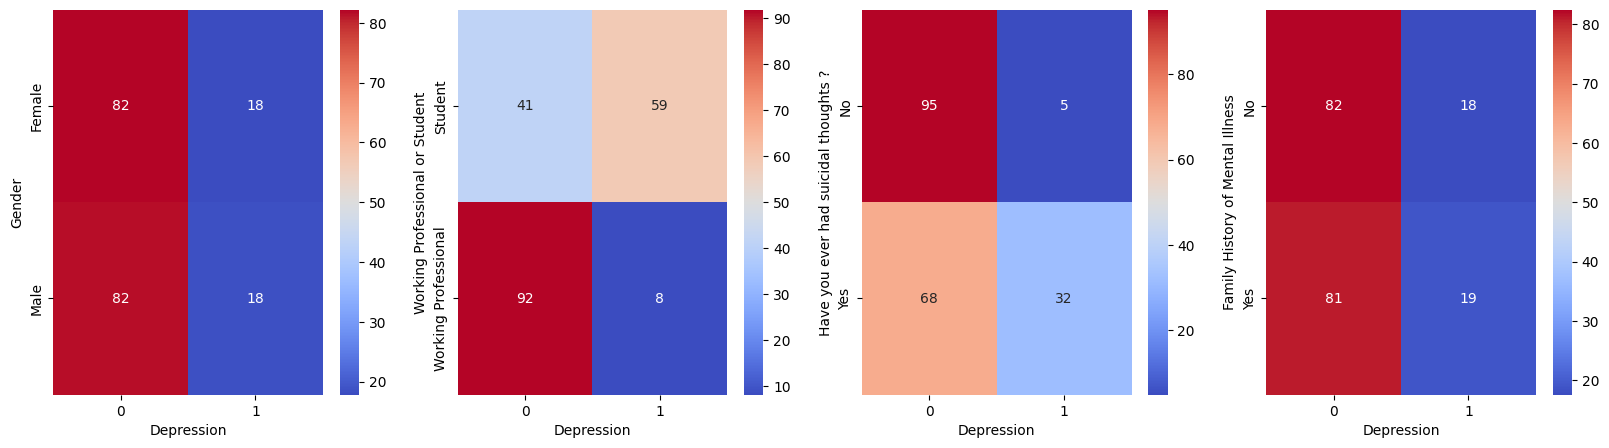

In [290]:
# Look at the relationship between the features and the target variable
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['Gender'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[0])
sns.heatmap(data=round(100*pd.crosstab(train['Working Professional or Student'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[1])
sns.heatmap(data=round(100*pd.crosstab(train["Have you ever had suicidal thoughts ?"], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[2])
sns.heatmap(data=round(100*pd.crosstab(train["Family History of Mental Illness"], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[3])
plt.show()

In [291]:
train.dtypes

Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

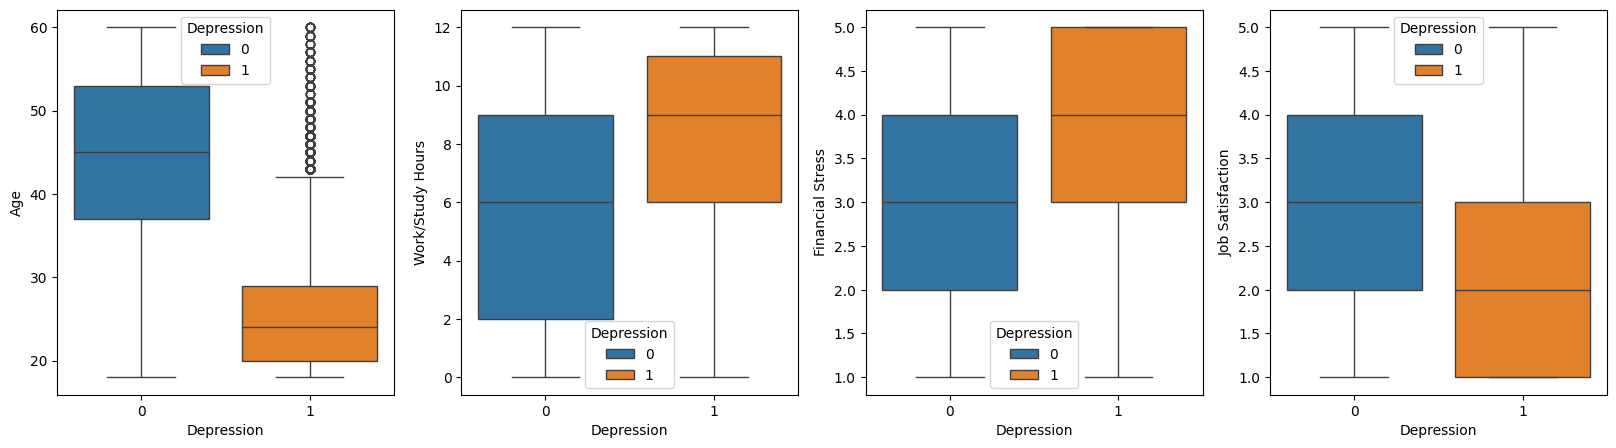

In [292]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x='Depression', y='Age', data=train, hue="Depression", ax=ax[0])
sns.boxplot(x='Depression', y='Work/Study Hours', data=train, hue="Depression", ax=ax[1])
sns.boxplot(x='Depression', y='Financial Stress', data=train, hue="Depression", ax=ax[2])
sns.boxplot(x='Depression', y='Job Satisfaction', data=train, hue="Depression", ax=ax[3])
plt.show()

## Preparing Data

I will be using the continuous data and categorical data with only two categories to keep it simple.

In [293]:
# Count the number of unique values for each categorical variable
for col in train.columns:
    if train[col].dtype == 'object':
        print(f"{col}: {train[col].nunique()} unique values")

Name: 422 unique values
Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


In [294]:
# Select the columns that are continuous and have 2 categories
selected_columns = [
    'Gender', 
    'Working Professional or Student', 
    'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness', 
    'Age', 
    'Work/Study Hours', 
    'Financial Stress', 
    'Job Satisfaction', 
]

# Prepare the data for training
X = train[selected_columns]
y = train['Depression']

# Drop the same columns from the test set
test_selected = test[selected_columns]

In [295]:
# One-hot encode the categorical variables

# Combine train and test to ensure consistent one-hot encoding
combined = pd.concat([X, test_selected], keys=['train', 'test'])

# One-hot encode the categorical variables
cat_cols = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into train and test sets
X = combined.xs('train')
test_selected = combined.xs('test')

In [296]:
# Check for NaNs in the data
print('--- Percentage of Missing Values in X_train ---\n')
print(X.isna().sum())
print('\n')
print('--- Percentage of Missing Values in y_train ---\n')
print(y.isna().sum())

--- Percentage of Missing Values in X_train ---

Age                                                         0
Work/Study Hours                                            0
Financial Stress                                            4
Job Satisfaction                                        27910
Gender_Male                                                 0
Working Professional or Student_Working Professional        0
Have you ever had suicidal thoughts ?_Yes                   0
Family History of Mental Illness_Yes                        0
dtype: int64


--- Percentage of Missing Values in y_train ---

0
Age                                                         0
Work/Study Hours                                            0
Financial Stress                                            4
Job Satisfaction                                        27910
Gender_Male                                                 0
Working Professional or Student_Working Professional        0
Have you ever had

In [297]:
# Fill missing values with the mean of the column for numeric columns
X = X.fillna(X.mean())
test_selected = test_selected.fillna(test_selected.mean())

# Ensure all values are numeric
X = X.apply(pd.to_numeric, errors='coerce')
test_selected = test_selected.apply(pd.to_numeric, errors='coerce')

In [298]:
X.describe()

,Age,Work/Study Hours,Financial Stress,Job Satisfaction,Gender_Male,Working Professional or Student_Working Professional,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes
count,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000
mean,40.388621,6.252679,2.988983,2.974404,0.550561,0.801699,0.494399,0.497100
std,12.384099,3.853615,1.413613,1.267871,0.497439,0.398722,0.499970,0.499993
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,42.000000,6.000000,3.000000,2.974404,1.000000,1.000000,0.000000,0.000000
75%,51.000000,10.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000
max,60.000000,12.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [299]:
# Separate continuous and categorical features
continuous_features = ['Age', 'Work/Study Hours', 'Financial Stress', 'Job Satisfaction']
categorical_features = [col for col in X.columns if col not in continuous_features]

# Apply StandardScaler to continuous features
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X[continuous_features])
test_selected_continuous = scaler.transform(test_selected[continuous_features])

# Combine scaled continuous features and categorical features
X_combined = np.hstack((X_continuous, X[categorical_features].values))
test_selected_combined = np.hstack((test_selected_continuous, test_selected[categorical_features].values))


In [300]:
# Split data into training and validation sets -> 80% train, 20% validation
train_size = int(0.8 * len(X_combined))
X_train, X_test = X_combined[:train_size], X_combined[train_size:]
y_train, y_test = y.values[:train_size], y.values[train_size:]

In [301]:
# Convert data into JAX arrays with specified dtype
X_train_arr = jnp.array(X_train, dtype=jnp.float32)
y_train_arr = jnp.array(y_train, dtype=jnp.float32).reshape(-1, 1)
X_test_arr = jnp.array(X_test, dtype=jnp.float32)
y_test_arr = jnp.array(y_test, dtype=jnp.float32).reshape(-1, 1)


## Create MLP using JAX
Creating a simple fully connected neural network in JAX/FLAX for predicting depression (binary classification)

In [302]:
# Define Neural Network (MLP)
class SimpleMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification

    # Define the MLP cell
    def setup(self):
        self.hidden_layer = nn.Dense(features=self.hidden_size)
        self.output_layer = nn.Dense(features=self.output_size)

    def __call__(self, x):
        x = self.hidden_layer(x)
        x = nn.relu(x)
        x = self.output_layer(x)
        return x

## Model Initialisation
In FLAX, you have to manually create and update train_state, which holds all the model's variables.
In Jax, you need a training state to encapsulate the model parameters, optimizer state, and 
apply function. This is easier to manage the JIT compliation and training loop.

In [303]:
# Create training state
def create_train_state(rng, X_train):
    X_batch = X_train[:1, :]  # Take a batch of the data to get the input size
    model = SimpleMLP(hidden_size=64, output_size=1)
    params = model.init(rng, X_batch)["params"]
    tx = optax.adam(learning_rate=1e-3)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)


In [304]:
# Initialis the training state
rng = jax.random.PRNGKey(0)
train_state = create_train_state(rng, X_train_arr)

## Loss & Metrics calculations
Create the functions which calculates the training loss and the accuracy using the given predicted values and labels


In [305]:
# Set up Training Loop, Loss Function and Optimizer
@jax.jit
def binary_cross_entropy_loss(logits, labels):
    # Compute binary cross-entropy loss
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    epsilon = 1e-7  # Small value to avoid log(0)
    loss = -jnp.mean(labels * jnp.log(preds + epsilon) + (1 - labels) * jnp.log(1 - preds + epsilon))
    return loss


# Forward pass and loss calculation (no need to pass the model class)
@jax.jit
def compute_loss(params, batch):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
    return binary_cross_entropy_loss(logits, labels)


## Training

In [306]:
# Training step function (do not pass the model itself)
@jax.jit
def train_step(state, batch):
    loss, grads = jax.value_and_grad(compute_loss)(state.params, batch)  # Compute loss and gradients
    state = state.apply_gradients(grads=grads)  # Apply updates to the model parameters
    return loss, state

# Validation step function
@jax.jit
def validate(params, batch):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
    loss = binary_cross_entropy_loss(logits, labels)
    return loss

# Accuracy calculation
def calculate_accuracy(logits, labels):
    preds = jax.nn.sigmoid(logits)
    predicted_classes = preds > 0.5
    return jnp.mean(predicted_classes == labels)

In [307]:
# # Set batch size and number of epochs
# batch_size = 32 
# num_epochs = 10 

# # Training loop
# start = time.time()
# for epoch in range(num_epochs):
#     # Shuffle data for each epoch
#     idx = jax.random.permutation(rng, X_train_arr.shape[0])
#     X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

#     # Iterate over batches
#     for i in range(0, len(X_train_arr), batch_size):
#         batch_features = X_train_arr[i:i + batch_size]
#         batch_labels = y_train_arr[i:i + batch_size]
#         batch = (batch_features, batch_labels)

#         # Perform one training step
#         loss, train_state = train_step(train_state, batch)

#     print(f"Epoch {epoch+1}, Loss: {loss}")

# print("Total time: ", time.time() - start, "seconds")

In [308]:
# # Set batch size and number of epochs
# batch_size = 32 
# num_epochs = 20  # Increased number of epochs

# # Training loop with validation
# train_losses, val_losses = [], []
# start = time.time()
# for epoch in range(num_epochs):
#     # Shuffle data for each epoch
#     idx = jax.random.permutation(rng, X_train_arr.shape[0])
#     X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

#     # Training
#     train_loss = 0.0
#     for i in range(0, len(X_train_arr), batch_size):
#         batch_features = X_train_arr[i:i + batch_size]
#         batch_labels = y_train_arr[i:i + batch_size]
#         batch = (batch_features, batch_labels)

#         # Perform one training step
#         loss, train_state = train_step(train_state, batch)
#         train_loss += loss

#     train_loss /= (len(X_train_arr) // batch_size)
#     train_losses.append(train_loss)

#     # Validation
#     val_loss = 0.0
#     for i in range(0, len(X_test_arr), batch_size):
#         batch_features = X_test_arr[i:i + batch_size]
#         batch_labels = y_test_arr[i:i + batch_size]
#         batch = (batch_features, batch_labels)

#         # Perform one validation step
#         loss = validate(train_state.params, batch)
#         val_loss += loss

#     val_loss /= (len(X_test_arr) // batch_size)
#     val_losses.append(val_loss)

#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# print("Total time: ", time.time() - start, "seconds")

In [ ]:
# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_test_arr), batch_size):
        batch_features = X_test_arr[i:i + batch_size]
        batch_labels = y_test_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, batch)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_test_arr) // batch_size)
    val_accuracy /= (len(X_test_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20, Training Loss: 0.2044, Validation Loss: 0.1878, Training Accuracy: 0.9164, Validation Accuracy: 0.9250
Epoch 2/20, Training Loss: 0.1873, Validation Loss: 0.1882, Training Accuracy: 0.9235, Validation Accuracy: 0.9236
Epoch 3/20, Training Loss: 0.1866, Validation Loss: 0.1857, Training Accuracy: 0.9242, Validation Accuracy: 0.9253
Epoch 4/20, Training Loss: 0.1862, Validation Loss: 0.1859, Training Accuracy: 0.9243, Validation Accuracy: 0.9252
Epoch 5/20, Training Loss: 0.1860, Validation Loss: 0.1869, Training Accuracy: 0.9245, Validation Accuracy: 0.9244
Epoch 6/20, Training Loss: 0.1859, Validation Loss: 0.1865, Training Accuracy: 0.9241, Validation Accuracy: 0.9239
Epoch 7/20, Training Loss: 0.1858, Validation Loss: 0.1858, Training Accuracy: 0.9245, Validation Accuracy: 0.9250
Epoch 8/20, Training Loss: 0.1856, Validation Loss: 0.1863, Training Accuracy: 0.9240, Validation Accuracy: 0.9245
Epoch 9/20, Training Loss: 0.1856, Validation Loss: 0.1866, Training Accuracy: 0

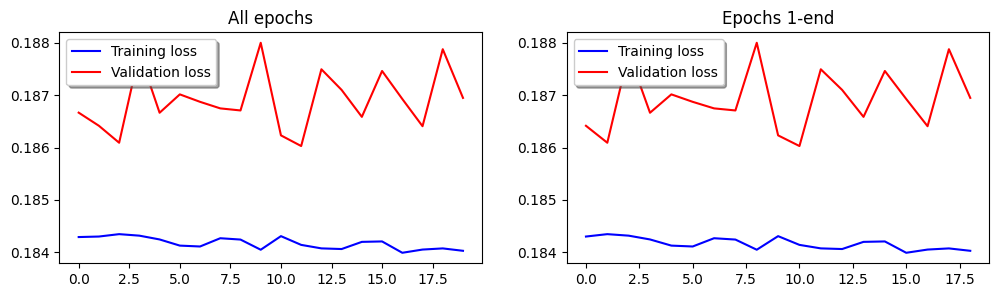

In [ ]:
# # Plotting the training and validation loss
# fig, ax = plt.subplots(1, 2, figsize=(12, 3))
# ax[0].plot(train_losses, color='b', label="Training loss")
# ax[0].plot(val_losses, color='r', label="Validation loss")
# ax[0].legend(loc='best', shadow=True)
# ax[0].set_title("All epochs")
# ax[1].plot(train_losses[1:], color='b', label="Training loss")
# ax[1].plot(val_losses[1:], color='r', label="Validation loss")
# ax[1].legend(loc='best', shadow=True)
# ax[1].set_title("Epochs 1-end")
# plt.show()

In [ ]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='b', label="Training loss")
ax[0, 0].plot(val_losses, color='r', label="Validation loss")
ax[0, 0].legend(loc='best', shadow=True)
ax[0, 0].set_title("Loss - All epochs")
ax[0, 1].plot(train_losses[1:], color='b', label="Training loss")
ax[0, 1].plot(val_losses[1:], color='r', label="Validation loss")
ax[0, 1].legend(loc='best', shadow=True)
ax[0, 1].set_title("Loss - Epochs 1-end")
ax[1, 0].plot(train_accuracies, color='b', label="Training accuracy")
ax[1, 0].plot(val_accuracies, color='r', label="Validation accuracy")
ax[1, 0].legend(loc='best', shadow=True)
ax[1, 0].set_title("Accuracy - All epochs")
ax[1, 1].plot(train_accuracies[1:], color='b', label="Training accuracy")
ax[1, 1].plot(val_accuracies[1:], color='r', label="Validation accuracy")
ax[1, 1].legend(loc='best', shadow=True)
ax[1, 1].set_title("Accuracy - Epochs 1-end")
plt.show()

In [ ]:
# Predict function
def predict(model, params, X):
    logits = model.apply({'params': params}, X)  # Get raw logits
    return jax.nn.sigmoid(logits)  # Apply sigmoid to get probabilities

# Example prediction on new data
X_new = np.random.rand(10, X_train_arr.shape[1])  # 10 new samples with the same number of features as the training data
X_new = jnp.array(X_new, dtype=jnp.float32)

# Get predictions (probabilities)
predictions = predict(SimpleMLP(hidden_size=64, output_size=1), train_state.params, X_new)
print(predictions)

[[0.02936059]
 [0.00958343]
 [0.0759645 ]
 [0.01151236]
 [0.11977473]
 [0.01307781]
 [0.13460281]
 [0.01964897]
 [0.02601002]
 [0.01123675]]
